In [124]:
%reload_ext autoreload
%autoreload 2

# Analysis 101

To do:
- colour-code points by the distance from the mean pH to contextualise the magnitude of experimental change in pH
- amalgamate any studies with n=1 since need sd for hedges
- deal with temperature-only studies (not all studies have carbonate chemistry)


In [125]:
### import
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# clustering
from sklearn.cluster import KMeans

# custom
import analysis, utils

In [126]:
climatology_df[climatology_df.index == "10.1111/jpy.13290"]

,data_ID,doi,location,mean_pH_30y_ensemble,models_with_data_n,mean_pH_30y_ensemble_se,MMM_30y_mean,geometry
10.1111/jpy.13290,1,"Lizard Island, GBR, Australia",8.086768,10,0.004111,29.046213,c(145.459236111111,-14.6922777777778)


In [127]:
### for one study, calculate the hedges g
i = 0   # index of test study
climatology_data_fp = "data/climatology/site_locations_with_MMM_and_pH.csv"
climatology_df = pd.read_csv(climatology_data_fp, index_col=2)
# drop the first column
climatology_df = climatology_df.drop(columns=climatology_df.columns[0])

## Multi-variable study

In [128]:
test_doi = climatology_df[climatology_df.index == "10.1111/jpy.13290"]
carb_df = pd.read_pickle("data/temp_carb_df.pkl")
test_df = carb_df.loc[carb_df["doi"] == test_doi.index[0]]
test_df.head()

,authors,calcification,calcification_sd,calcification_se,calcification_units,cleaned_coords,co3,co3_sd,co3_se,coords,...,secondary_check,species_types,t_in,t_in_sd,t_in_se,ta,ta_sd,ta_se,taxa,year
0,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.970803,NaN,0.25555,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,210.0,NaN,2.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,27.1,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01
1,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,2.408759,NaN,0.18976,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,214.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,29.4,NaN,0.08,2291.0,NaN,1.0,Algae,2023-01-01
2,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.664234,NaN,0.167864,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,117.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,27.2,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01
3,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.839416,NaN,0.124074,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,125.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,29.5,NaN,0.08,2291.0,NaN,1.0,Algae,2023-01-01
4,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.467626,NaN,0.131372,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,210.0,NaN,2.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Lithophyllum cf insipidum,27.1,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01


In [164]:
# assign species_types values to unique ints
species_types = test_df["species_types"].unique()
species_types_dict = {species_type: i for i, species_type in enumerate(species_types)}
test_df.loc[:,"species_types"] = test_df["species_types"].map(species_types_dict)

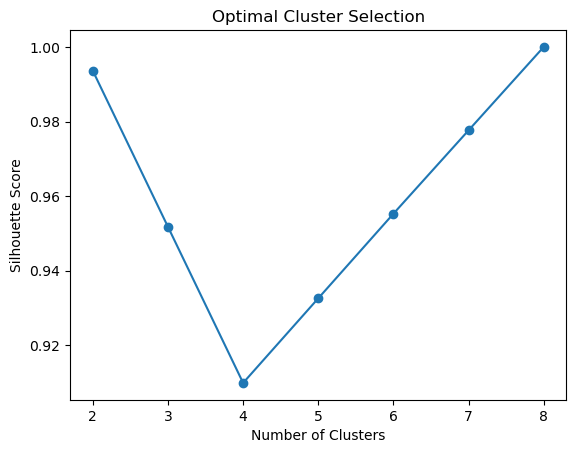

In [168]:
# subset = test_df[test_df["species_types"] == "Porollithon cf onkodes"]
subset = test_df
# Select relevant columns
treatment_data = subset[['t_in', 'phtot', 'irr']].dropna()

# Find optimal number of clusters
optimal_k, score_list = utils.optimal_kmeans(treatment_data)

# Fit KMeans with the best number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
subset.loc[:,'treatment_group'] = kmeans.fit_predict(treatment_data)

# Split dataframe into separate treatments
treatment_groups = {name: group for name, group in subset.groupby('treatment_group')}

# Optional: Plot Silhouette Scores
plt.plot(*zip(*score_list), marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Cluster Selection')
plt.show()

In [169]:
for tg in treatment_groups.values():
    print("TREATMENT GROUP {}".format(tg['treatment_group'].iloc[0]))
    print(tg.loc[:,['t_in', 'phtot', 'irr', 'species_types']])

TREATMENT GROUP 0
   t_in  phtot    irr  species_types
1  29.4   7.98  250.0              0
5  29.4   7.98  250.0              1
TREATMENT GROUP 1
    t_in  phtot   irr  species_types
9   29.4   7.98  30.0              2
13  29.4   7.98  30.0              3
TREATMENT GROUP 2
   t_in  phtot    irr  species_types
2  27.2  7.698  250.0              0
6  27.2  7.698  250.0              1
TREATMENT GROUP 3
    t_in  phtot   irr  species_types
8   27.1  8.003  30.0              2
12  27.1  8.003  30.0              3
TREATMENT GROUP 4
   t_in  phtot    irr  species_types
0  27.1  8.003  250.0              0
4  27.1  8.003  250.0              1
TREATMENT GROUP 5
    t_in  phtot   irr  species_types
10  27.2  7.698  30.0              2
14  27.2  7.698  30.0              3
TREATMENT GROUP 6
   t_in  phtot    irr  species_types
3  29.5  7.694  250.0              0
7  29.5  7.694  250.0              1
TREATMENT GROUP 7
    t_in  phtot   irr  species_types
11  29.5  7.694  30.0              2
15  2

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_48218/45990617.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono_var_subset.loc[:, 'calcification_sd'] = mono_var_subset[['calcification_se', 'n']].apply(lambda row: analysis.calc_sd_from_se(row['calcification_se'], row['n']), axis=1)


Text(0, 0.5, "Hedge's g")

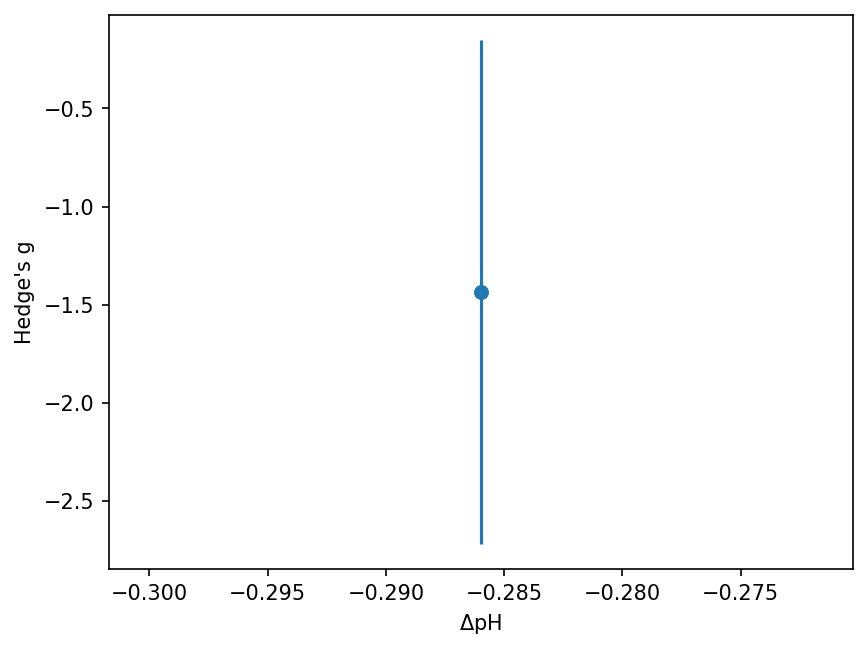

In [ ]:
### artificially reducing to single group (same species, constant T and irradiance, changing pH)
# mono_var_subset = pd.concat(treatment_groups)
mono_var_subset = treatment_groups[0]

cols = ['t_in', 'phtot', 'irr', 'calcification', 'calcification_se', 'n']
mono_var_subset = mono_var_subset[cols]
mono_var_subset.loc[:, 'calcification_sd'] = mono_var_subset[['calcification_se', 'n']].apply(lambda row: analysis.calc_sd_from_se(row['calcification_se'], row['n']), axis=1)
mono_var_subset


t1 = mono_var_subset.iloc[0]
t2 = mono_var_subset.iloc[1]

# TODO: colour-code by the distance from the mean pH to contextualise the magnitude of experimental change in pH

hg, (hg_ci_l, hg_ci_u) = analysis.calc_hedges_g(t2["calcification"], t1["calcification"], t2["calcification_sd"], t1["calcification_sd"], t2["n"], t1["n"])
delta_ph = t2["phtot"] - t1["phtot"]

fig, ax = plt.subplots(1, 1, dpi=150)
plt.scatter(delta_ph, hg)
plt.errorbar(delta_ph, hg, yerr=[[hg-hg_ci_l], [hg_ci_u-hg]], fmt='o')
# formatting
plt.xlabel("$\\Delta$pH")
plt.ylabel("Hedge's g")

# GPT to scale


In [201]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use your existing function to determine optimal clusters
def optimal_kmeans(data, max_clusters=8):
    best_k = 2  # Minimum sensible number of clusters
    best_score = -1
    scores = []

    for k in range(2, min(len(data), max_clusters + 1)):  # Avoid excessive clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=max_clusters)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        scores.append((k, score))

        if score > best_score:
            best_score = score
            best_k = k

    return best_k, scores

# Function to apply clustering
def cluster_treatments(df, vars_to_cluster):
    """Cluster treatments based on independent variables."""
    # only keep variables with no missing values
    treatment_data = df[vars_to_cluster].dropna(axis=1)
    
    # treatment_data = df[vars_to_cluster].dropna()

    # Determine the best number of clusters
    # Fit KMeans with the optimal number of clusters
    try:
        optimal_k, _ = optimal_kmeans(treatment_data)

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        df.loc[:, 'treatment_group'] = kmeans.fit_predict(treatment_data)
    except ValueError:
        print(f"Error: Could not cluster {df['doi'].iloc[0]}")
        df.loc[:, 'treatment_group'] = np.nan

    return df

# Function to find the extreme conditions within each treatment group
def find_extreme_conditions(df):
    """Identify the rows corresponding to min temperature, max pH, and max light per group."""
    grouped = df.groupby('treatment_group')

    extreme_treatments = {}

    for group, sub_df in grouped:
        min_temp = sub_df.loc[sub_df['t_in'].idxmin()]  # Row with minimum temperature
        max_pH = sub_df.loc[sub_df['phtot'].idxmax()]   # Row with maximum pH
        max_light = sub_df.loc[sub_df['irr'].idxmax()]  # Row with maximum light

        extreme_treatments[group] = {
            'min_temp': min_temp,
            'max_pH': max_pH,
            'max_light': max_light
        }

    return extreme_treatments




# # Main execution
# independent_vars = ['phtot', 't_in', 'irr']
# study_column = 'doi'  # Column indicating different studies

# # Step 1: Process Each Study Separately
# all_results = []

for study_name, study_df in carb_df.groupby('doi'):
    print(f"Processing study: {study_name}")
    
    if len(study_df) < 2:
        print(f"Skipping study {study_name} due to insufficient data for hedges g calculation.")
        continue
    
#     # Step 2: Cluster Treatments Within the Study
    study_df = cluster_treatments(study_df, independent_vars)

#     # Step 3: Identify Extreme Conditions (min_temp, max_pH, max_light)
#     extreme_conditions = find_extreme_conditions(study_df)

#     # Step 4: Compute Hedges’ g for Min Temp, Max pH, Max Light
#     hedges_results = compute_hedges_g(study_df, extreme_conditions)
    
#     # Store the results for this study
#     all_results.append(hedges_results)

# # Combine all study results into a single dataframe
# final_results = pd.concat(all_results, ignore_index=True)

# print(final_results)


Processing study: 10.1007/s00227-016-2986-8
Processing study: 10.1007/s00227-022-04071-6
Processing study: 10.1007/s00338-012-0952-6
Processing study: 10.1007/s00338-019-01775-y
Processing study: 10.1007/s00338-020-01995-7
Error: Could not cluster 10.1007/s00338-020-01995-7
Processing study: 10.1007/s13131-022-2037-x
Processing study: 10.1016/j.chemgeo.2018.09.004


/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  re

Processing study: 10.1016/j.ecochg.2021.100016
Processing study: 10.1016/j.jembe.2016.10.002
Processing study: 10.1016/j.jembe.2019.151225
Processing study: 10.1016/j.marenvres.2023.106150
Processing study: 10.1029/2020JG005726
Error: Could not cluster 10.1029/2020JG005726
Processing study: 10.1038/s41598-019-40620-8
Processing study: 10.1038/s41598-022-06896-z
Processing study: 10.1038/s42003-022-04353-1
Processing study: 10.1088/1755-1315/253/1/012022


/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  re

Processing study: 10.1093/icesjms/fsaa015
Processing study: 10.1098/rsos.170683
Processing study: 10.1098/rsos.220760
Processing study: 10.1098/rspb.2019.0614
Processing study: 10.1098/rspb.2021.0923
Processing study: 10.1111/gcb.13481


/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  re

Processing study: 10.1111/gcb.14998
Processing study: 10.1111/jpy.13290
Processing study: 10.1111/maec.12444
Processing study: 10.1186/s40168-023-01653-4
Processing study: 10.1371/journal.pone.0139223
Processing study: 10.3354/meps09309
Processing study: 10.3354/meps10981
Processing study: 10.3354/meps11591
Processing study: 10.3389/fmars.2020.581160
Skipping study 10.3389/fmars.2020.581160 due to insufficient data for hedges g calculation.
Processing study: 10.3389/fmars.2021.704487
Processing study: 10.3389/fmars.2022.872631
Processing study: 10.3390/jmse10081106
Processing study: 10.3390/jmse9070739


/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

In [187]:
study_df.n

998     5.0
999     5.0
1000    5.0
1001    5.0
1002    5.0
1003    5.0
1004    5.0
1005    5.0
1006    4.0
1007    4.0
1008    4.0
1009    4.0
Name: n, dtype: object